Loading FastText model...
Generating FastText embeddings...


100%|██████████| 18082/18082 [00:00<00:00, 37276.87it/s]


Before SMOTE: [1091 3776 1489 6499 5227]
After SMOTE: [6499 6499 6499 6499 6499]
Train-Test Split done (80/20)
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Loss=1.1330, Accuracy=0.6015, F1 Score=0.6209
Epoch 2: Loss=0.7225, Accuracy=0.7295, F1 Score=0.7191
Epoch 3: Loss=0.6841, Accuracy=0.7412, F1 Score=0.7402
Epoch 4: Loss=0.6522, Accuracy=0.7610, F1 Score=0.7559
Epoch 5: Loss=0.6216, Accuracy=0.7687, F1 Score=0.7650
Epoch 6: Loss=0.6166, Accuracy=0.7729, F1 Score=0.7648
Epoch 7: Loss=0.5998, Accuracy=0.7838, F1 Score=0.7780
Epoch 8: Loss=0.5718, Accuracy=0.7852, F1 Score=0.7836
Epoch 9: Loss=0.5590, Accuracy=0.7909, F1 Score=0.7862
Epoch 10: Loss=0.5709, Accuracy=0.7920, F1 Score=0.7863
Epoch 11: Loss=0.5683, Accuracy=0.7870, F1 Score=0.7833
Epoch 12: Loss=0.5312, Accuracy=0.8044, F1 Score=0.8017
Epoch 13: Loss=0.5440, Accuracy=0.7992, F1 Score=0.7977
Epoch 14: Loss=0.5205, Accuracy=0.8103, F1 Score=0.8064
Epoch 15: Loss=0.5148, Accuracy=0.8097, F1 Score=0.8092

✅ Restoring best model from epoch 15 with F1 Score: 0.8092
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Final Evaluation Summary:
✅ Accuracy   : 0.8097
✅ F1 Score   : 0.

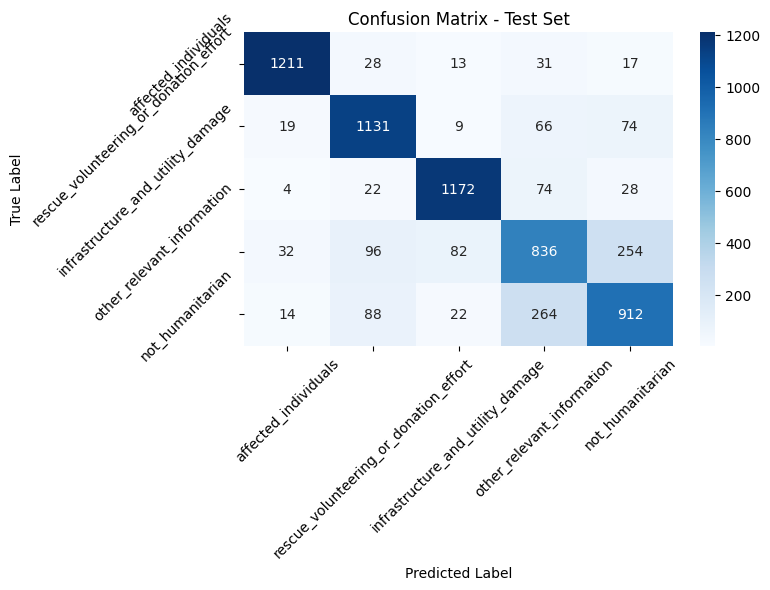

✅ Best model saved as 'best_humanitarian_model.h5'


In [20]:
# ========== Imports ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess ==========
df.columns = df.columns.str.strip()
df['Humanitarian_Class'] = df['Humanitarian_Class'].fillna('not_humanitarian').str.strip().str.lower()
df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Label Encoding ==========
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['Humanitarian_Class'].map(label_map)

# ========== Load FastText ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== FastText Embedding Function ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

# ========== Generate Embeddings for Full Data ==========
print("Generating FastText embeddings...")
X_full = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(df['Processed_data'])])
y_full = df['label'].values

# ========== Apply SMOTE Before Splitting ==========
print("Before SMOTE:", np.bincount(y_full))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_full, y_full)
print("After SMOTE:", np.bincount(y_resampled))

# ========== Train-Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42
)
print("Train-Test Split done (80/20)")

# ========== Custom Callback to Track Metrics ==========
class MetricsCallback(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        f1 = f1_score(self.y_test, y_pred, average='macro')
        acc = accuracy_score(self.y_test, y_pred)
        loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)[0]

        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}, F1 Score={f1:.4f}")

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_epoch = epoch + 1
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        print(f"\n✅ Restoring best model from epoch {self.best_epoch} with F1 Score: {self.best_f1:.4f}")
        self.model.set_weights(self.best_weights)

# ========== Define Model ==========
model = Sequential([
    Dense(512, activation='relu', input_shape=(embedding_dim,)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ========== Train Model ==========
print("Training model...")
metrics_callback = MetricsCallback(X_test, y_test)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    callbacks=[metrics_callback],
    verbose=0
)

# ========== Final Evaluation ==========
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

final_acc = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred, average='macro')
final_report = classification_report(y_test, y_pred, target_names=label_map.keys())

print("\n📊 Final Evaluation Summary:")
print(f"✅ Accuracy   : {final_acc:.4f}")
print(f"✅ F1 Score   : {final_f1:.4f}")
print("✅ Classification Report:\n", final_report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# ========== Save Final Model ==========
model.save("best_humanitarian_model.h5")
print("✅ Best model saved as 'best_humanitarian_model.h5'")
